In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import re
%run functions.py
import pickle

import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA

from sklearn.mixture import GMM
from sklearn import mixture
from sklearn.mixture import GaussianMixture

from nltk import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer

from gensim.matutils import Sparse2Corpus
from gensim import models

%matplotlib inline

import matplotlib.gridspec as gridspec

from subprocess import check_output

from wordcloud import WordCloud,STOPWORDS

import warnings
warnings.filterwarnings("ignore")

In [2]:
cn = sqlite3.connect('../database.sqlite')

### Create dataframe with column for paper_text which will be used for NLP Analysis

In [9]:
df = pd.read_sql_query('''SELECT papers.id AS id, year, title, pdf_name, abstract, paper_text, author_id, name 
AS author FROM papers JOIN paper_authors ON paper_authors.paper_id = papers.id
JOIN authors ON authors.id = paper_authors.author_id ORDER BY papers.id''', cn)

In [13]:
df.shape

(20838, 8)

In [10]:
df.head()

,id,year,title,pdf_name,abstract,paper_text,author_id,author
0,1,1987,Self-Organization of Associative Database and ...,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,Hisashi Suzuki
1,1,1987,Self-Organization of Associative Database and ...,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,2,Suguru Arimoto
2,2,1987,The Capacity of the Kanerva Associative Memory...,2-the-capacity-of-the-kanerva-associative-memo...,Abstract Missing,184\n\nTHE CAPACITY OF THE KANERVA ASSOCIATIVE...,3,Philip A. Chou
3,3,1987,Supervised Learning of Probability Distributio...,3-supervised-learning-of-probability-distribut...,Abstract Missing,52\n\nSupervised Learning of Probability Distr...,252,Eric B. Baum
4,3,1987,Supervised Learning of Probability Distributio...,3-supervised-learning-of-probability-distribut...,Abstract Missing,52\n\nSupervised Learning of Probability Distr...,7094,Frank Wilczek


### sqllite used to make df and create chart

In [6]:
authors=pd.read_sql_query('SELECT * FROM authors', cn)

In [8]:
paper_authors=pd.read_sql_query('''SELECT * FROM paper_authors''', cn)

In [11]:
year_counts = pd.read_sql_query('SELECT year, COUNT(*) as num_papers FROM papers GROUP BY year', cn)

Text(0.5,1,'Highest number of papers published authors')

<Figure size 432x288 with 0 Axes>

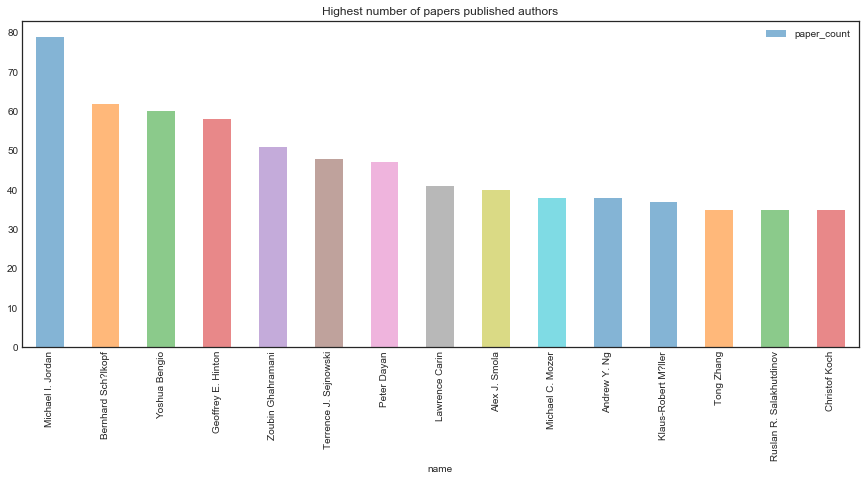

In [16]:
author_paper_count = paper_authors[["author_id","paper_id"]].groupby("author_id").count().sort_values(by="paper_id",ascending=False).reset_index()
author_paper_count = author_paper_count.rename(columns = {'paper_id':'paper_count'})
authors_ew = authors.rename(columns = {'id':'author_id'})
author_paper_count = pd.merge(author_paper_count, authors_new, on="author_id",how="left")
top15_authorsbycount = author_paper_count.iloc[:,1:].head(15)
plt.figure()
top15_authorsbycount.plot(x="name",y ="paper_count", kind='bar', alpha=0.55, figsize=(15,6))
plt.title("Highest number of papers published authors")

## Store paper_text in mongodb

In [334]:
from pymongo import MongoClient


In [335]:
client = MongoClient()


In [337]:
db = client.nipspapers


In [338]:
collection = db.paper_text


In [360]:
my_texts=list(df['paper_text'])

In [361]:
type(my_texts)

list

In [370]:
t = {str(key):type(text) for key,text in enumerate(my_texts)}
type(t)

dict

In [373]:
results = db.collection.insert(t)


# NLP

In [51]:
# tfidf outperformed count vectorizer
'''cv = CountVectorizer(ngram_range=(1,ngram), stop_words='english', max_df=0.9, min_df=2, max_features=num_features,tokenizer=tokenize_and_stem)
   cv_sparse_matrix = cv.fit_transform(df[column_name]) 
    '''

In [43]:
#dont need to show multiple authors for each paper since titles are all unique.
df=drop_duplicate_papers(df)
print(df.shape)
print(df.head(3))

(7238, 8)
   id  year                                              title  \
0   1  1987  Self-Organization of Associative Database and ...   
2   2  1987  The Capacity of the Kanerva Associative Memory...   
3   3  1987  Supervised Learning of Probability Distributio...   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   
2  2-the-capacity-of-the-kanerva-associative-memo...  Abstract Missing   
3  3-supervised-learning-of-probability-distribut...  Abstract Missing   

                                          paper_text  author_id  \
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...          1   
2  184\n\nTHE CAPACITY OF THE KANERVA ASSOCIATIVE...          3   
3  52\n\nSupervised Learning of Probability Distr...        252   

           author  
0  Hisashi Suzuki  
2  Philip A. Chou  
3    Eric B. Baum  


In [44]:
#clean texts in each of the columns
df['paper_text'] = df['paper_text'].apply(lambda x: clean(x))
df['title'] = df['title'].apply(lambda x: clean(x))

In [82]:
df['paper_text'].iloc[1]

' the capacity of the kanerva associative memory is exponential p a choul stanford university stanford ca abstract the capacity of an associative memory is defined as the maximum number of vords that can be stored and retrieved reliably by an address vithin a given sphere of attraction it is shown by sphere packing arguments that as the address length increases the capacity of any associati ve memory is limited to an exponential grovth rate of h vhere h is the binary entropy function in bits and is the radius of the sphere of attraction this exponential grovth in capacity can actually be achieved by the kanerva associative memory if its parameters are optimally set formulas for these op timal values are provided the exponential grovth in capacity for the kanerva associative memory contrasts sharply vith the sub linear grovth in capacity for the hopfield associative memory associative memory and its capacity our model of an associative memory is the folloving let y be an address datum p

In [45]:
df.head()

,id,year,title,pdf_name,abstract,paper_text,author_id,author
0,1,1987,self organization of associative database and ...,1-self-organization-of-associative-database-an...,abstract missing,self organization of associative database and...,1,Hisashi Suzuki
2,2,1987,the capacity of the kanerva associative memory...,2-the-capacity-of-the-kanerva-associative-memo...,abstract missing,the capacity of the kanerva associative memor...,3,Philip A. Chou
3,3,1987,supervised learning of probability distributio...,3-supervised-learning-of-probability-distribut...,abstract missing,supervised learning of probability distributi...,252,Eric B. Baum
5,4,1987,constrained differential optimization,4-constrained-differential-optimization.pdf,abstract missing,constrained differential optimization john c ...,4,John C. Platt
7,5,1987,towards an organizing principle for a layered ...,5-towards-an-organizing-principle-for-a-layere...,abstract missing,towards an organizing principle for a layered...,6,Ralph Linsker


In [48]:
#df_check=df[df['abstract']=='abstract missing']
#print(df_check.shape)
df.shape

(7238, 8)

In [33]:
#wordcloud
'''def realdata(papertexts):
    s = ""
    for i in range(len(papertexts)):
        w_list = papertexts[i].split()
        indexvalue= w_list.index("abstract")+1 if "abstract" in w_list else 0
        s = s+ " ".join( w_list[indexvalue: ] )
    return s

papers = pd.read_csv("../papers.csv")
papertext = papers['paper_text'].str.lower()
completestring = realdata(papertext)

stopwords = STOPWORDS
stopwords.update(["this","that","thus","from","does","example","however","since","given","et","al"])
wordcloud = WordCloud(
                      stopwords=stopwords,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(completestring)
plt.figure( figsize =(15,6))
plt.imshow(wordcloud)
plt.axis('off')

''';

In [288]:
def plot_docs_by_year(df):
    plt.figure(figsize=(10,6))
    ax = sns.countplot(x=df['year'],palette='plasma')
    
    # Prettify
    sns.set_style('ticks')
    plt.title('Total Papers published by Year', fontsize=25)
    plt.xlabel('Year', fontsize=20)
    plt.ylabel('Total Papers published', fontsize=20)
    
    plt.xticks(fontsize=14,rotation='vertical')
    plt.yticks(fontsize=14)


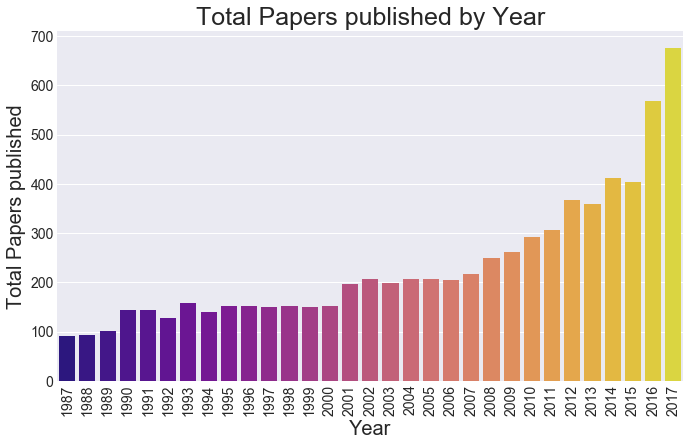

In [289]:
plot_docs_by_year(df)

In [57]:
tfidf_vectorizer, tfidf_sparse = create_tfidf(df=df,column_name='paper_text',num_features=2000)

In [6]:
'''
pickle_(df, 'df_clean')
pickle_(count_vectorizer, 'count_vectorizer')
pickle_(count_sparse, 'count_sparse')
pickle_(tfidf_vectorizer, 'tfidf_vectorizer')
pickle_(tfidf_sparse, 'tfidf_sparse')
''';

In [62]:
pd.DataFrame(count_sparse.toarray(), columns=count_vectorizer.get_feature_names()).head()

,aaai,ab,abil,abl,abov,absenc,absolut,ac,acceler,accept,...,z,zero,zhang,zhou,zhu,zi,zj,zk,zn,zt
0,0,0,0,0,1,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,7,0,0,0,0,0,0,0,0,0
2,0,0,1,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,2,0,0,0,0,0,0,0,0,0
4,0,0,0,0,5,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


In [63]:
pd.DataFrame(tfidf_sparse.toarray(), columns=tfidf_vectorizer.get_feature_names()).head()

,aaai,ab,abil,abl,abov,absenc,absolut,ac,acceler,accept,...,z,zero,zhang,zhou,zhu,zi,zj,zk,zn,zt
0,0.0,0.0,0.000000,0.000000,0.006162,0.0,0.000000,0.0,0.014408,0.027951,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.006532,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.036101,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.018356,0.029363,0.000000,0.0,0.000000,0.0,0.000000,0.025025,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.008731,0.0,0.000000,0.000000,...,0.009174,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.021891,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.009561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:

df=unpickle_('df_clean.pickle')
count_vectorizer=unpickle_('count_vectorizer.pickle')
count_sparse=unpickle_('count_sparse.pickle')
tfidf_vectorizer=unpickle_('tfidf_vectorizer.pickle')
tfidf_sparse=unpickle_('tfidf_sparse.pickle')


In [126]:
print(count_vectorizer.get_feature_names())

['aaai', 'ab', 'abil', 'abl', 'abov', 'absenc', 'absolut', 'ac', 'acceler', 'accept', 'access', 'accord', 'account', 'accumul', 'accur', 'accuraci', 'achiev', 'acknowledg', 'acm', 'acoust', 'acquisit', 'act', 'action', 'activ', 'actor', 'actual', 'ad', 'adaboost', 'adam', 'adapt', 'add', 'addit', 'address', 'adjac', 'adjust', 'admm', 'adopt', 'advanc', 'advantag', 'adversari', 'affect', 'affin', 'agent', 'aggreg', 'agreement', 'ai', 'aij', 'aim', 'aistat', 'aj', 'ak', 'al', 'algebra', 'algorithm', 'align', 'alloc', 'allow', 'alon', 'alreadi', 'altern', 'alway', 'ambigu', 'american', 'amplitud', 'analog', 'analys', 'analysi', 'analyt', 'analyz', 'andrew', 'angl', 'ani', 'anim', 'ann', 'annal', 'anneal', 'annot', 'annual', 'anoth', 'answer', 'ap', 'appear', 'appendix', 'appli', 'applic', 'approach', 'appropri', 'approxim', 'ar', 'arbitrari', 'arbitrarili', 'architectur', 'area', 'arg', 'argmin', 'argu', 'argument', 'aris', 'arm', 'array', 'arriv', 'art', 'articl', 'artifici', 'arxiv', 'a